In [1]:
import numpy as np
import pandas as pd
import json
import os
import glob
import cv2
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists('./masks'):
    os.mkdir('./masks')

In [3]:
images_path = '../input/nenets-walruses/Датасет/images'
markup_path = '../input/nenets-walruses/Датасет/markup'

images = sorted(glob.glob(images_path+'/*.jpg'))
markups = [filename.replace('images', 'markup').replace('jpg', 'json') for filename in images]
im_mark_pairs = list(zip(images, markups))
len(images), len(markups)

(200, 200)

In [4]:
# markup example
json1_file = open(markup_path + '/104.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
len(json1_data)

244

In [5]:
json1_data_0 = json1_data[0]
json1_data_0

{'id': 1,
 'segmentation_poly': [[291.0,
   155.5,
   297.5,
   149.0,
   299.5,
   141.0,
   320.5,
   121.0,
   313.0,
   112.5,
   298.0,
   117.5,
   283.5,
   132.0,
   280.5,
   147.0,
   285.0,
   153.5]],
 'bbox': [280.5, 112.5, 40.0, 43.0, 0.0],
 'category_id': 1,
 'tracker_id': None,
 'segmentation': None,
 'comment': '',
 'is_key_frame': True,
 'orientation': None,
 'type': 'poly',
 'tag_list': []}

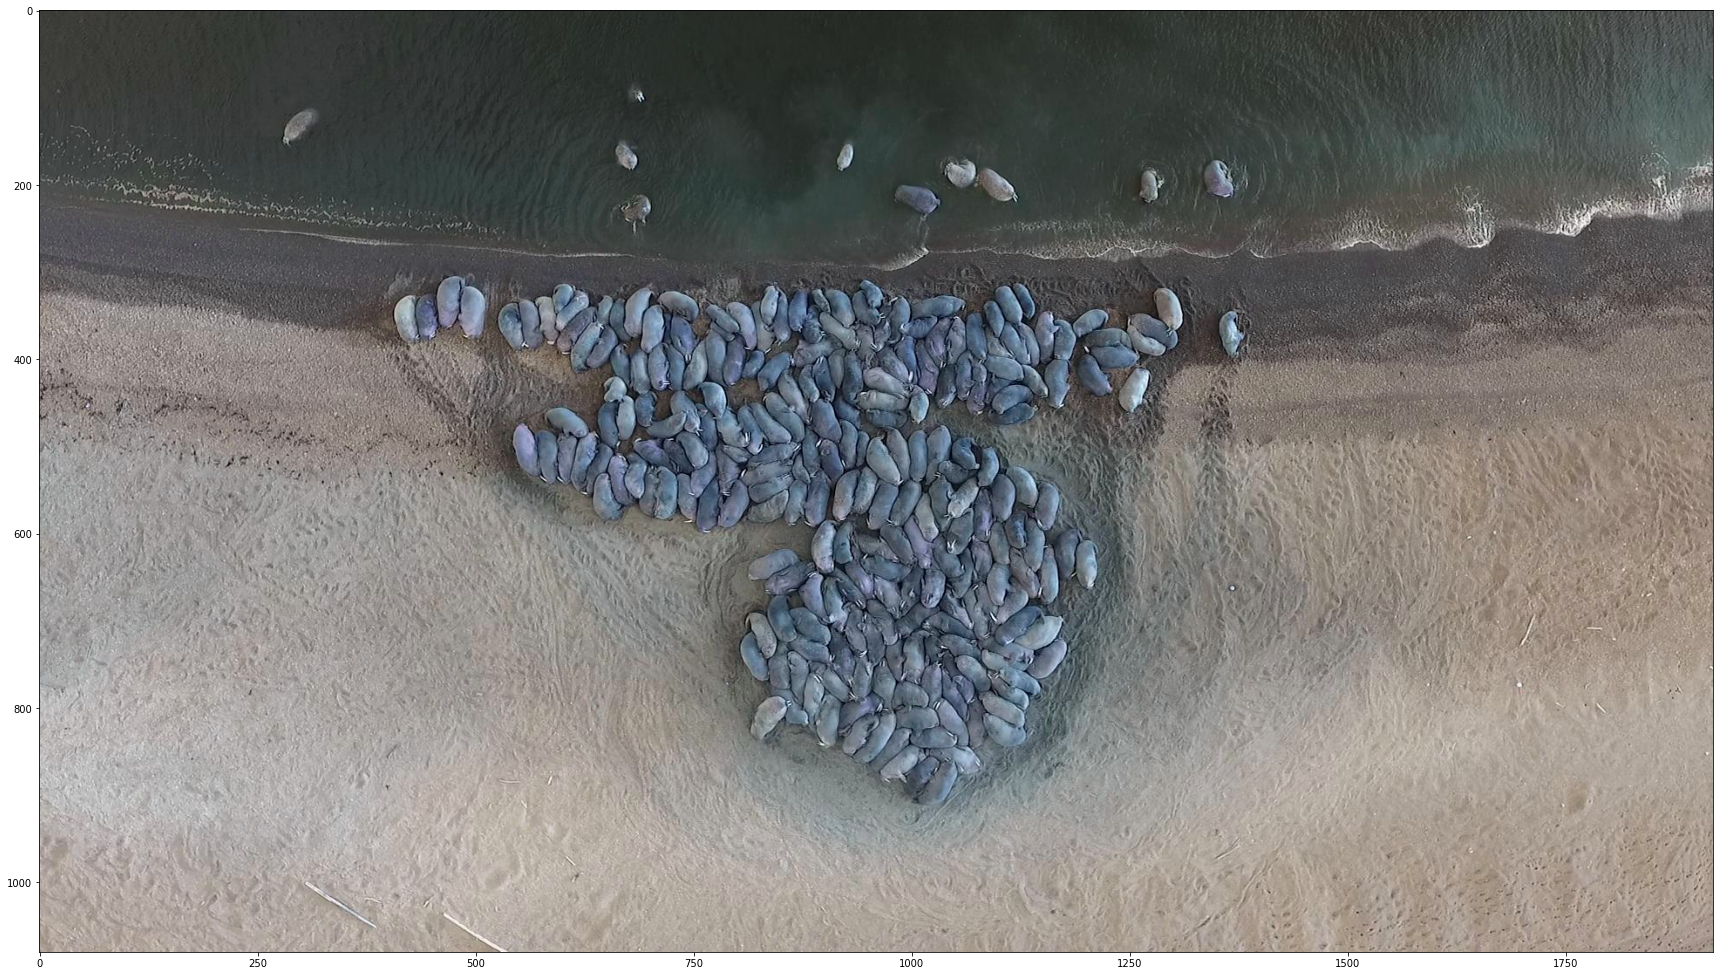

In [6]:
# example image
plt.figure(figsize=(30, 20))
img_example = cv2.imread(images_path + '/104.jpg')
plt.imshow(img_example)

Example mask

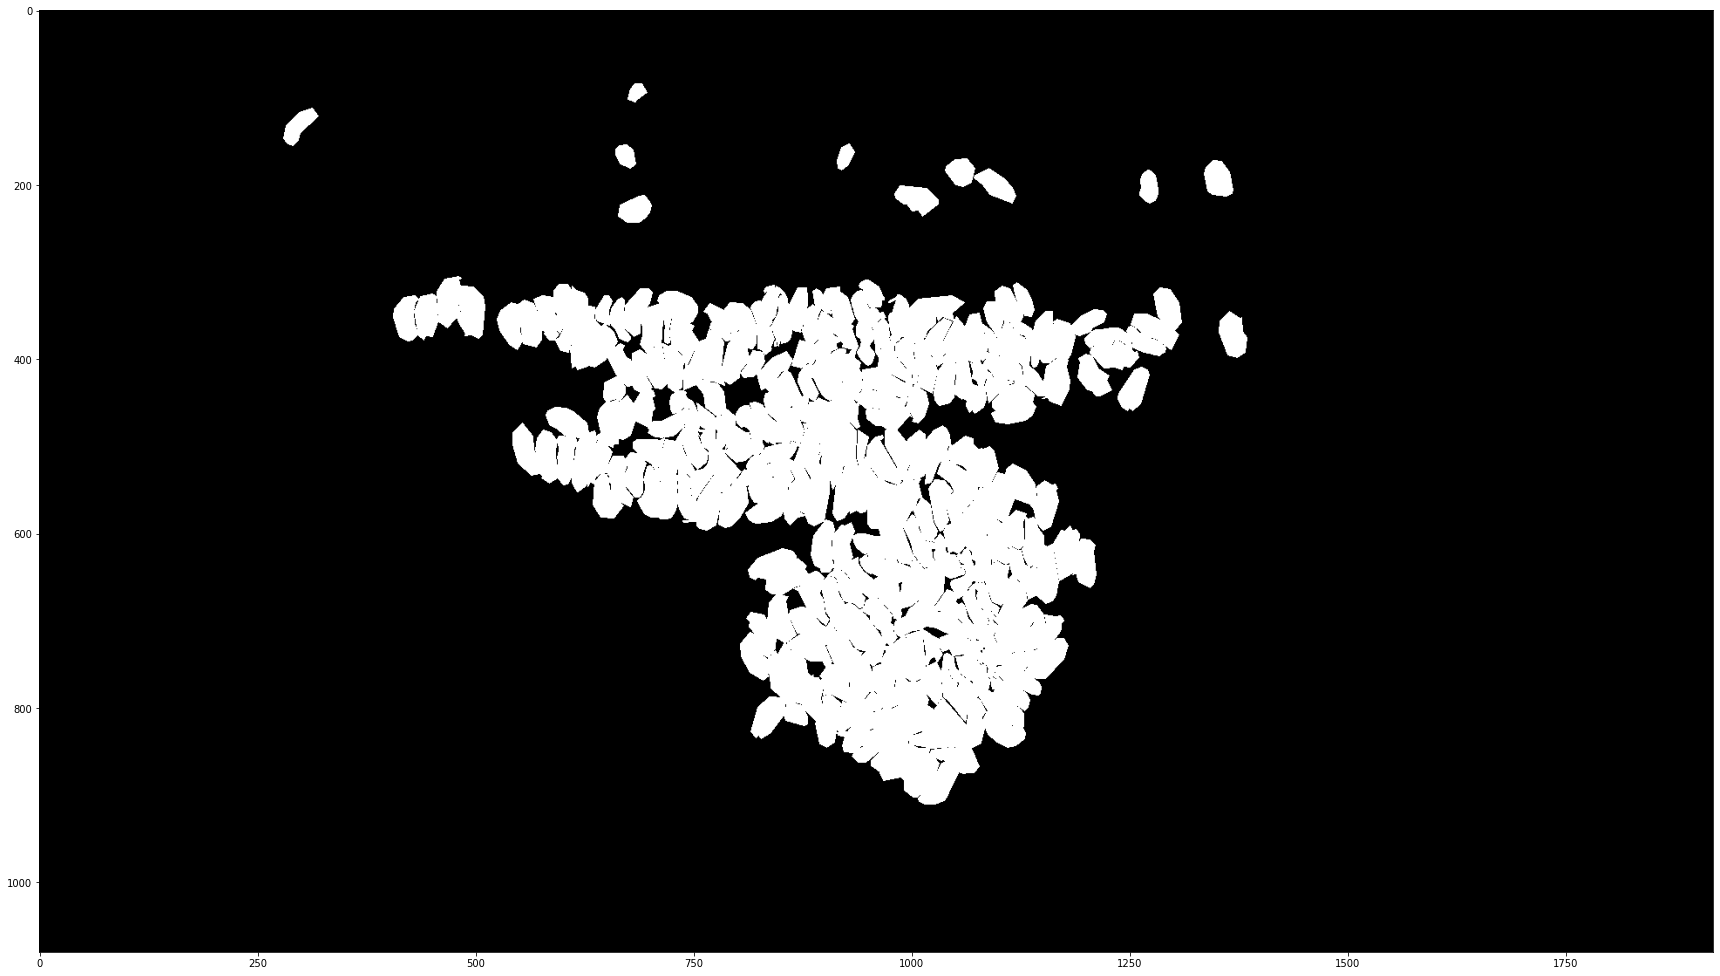

In [7]:
def image_to_mask(img_example, markup, countour=False):
    image = np.zeros((img_example.shape[0], img_example.shape[1], 3), np.uint8)
    image[:] = (0, 0, 0)

    for item in markup:
        pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
        image = cv2.fillPoly(image, [pts], (255,255,255) )
        if countour:
            image = cv2.polylines(image, [pts], True, (255,0,0), 1)
        else:
            pass
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    return image

image_mask = image_to_mask(img_example, json1_data)
plt.figure(figsize=(30, 20))
plt.imshow(image_mask)

Heat maps

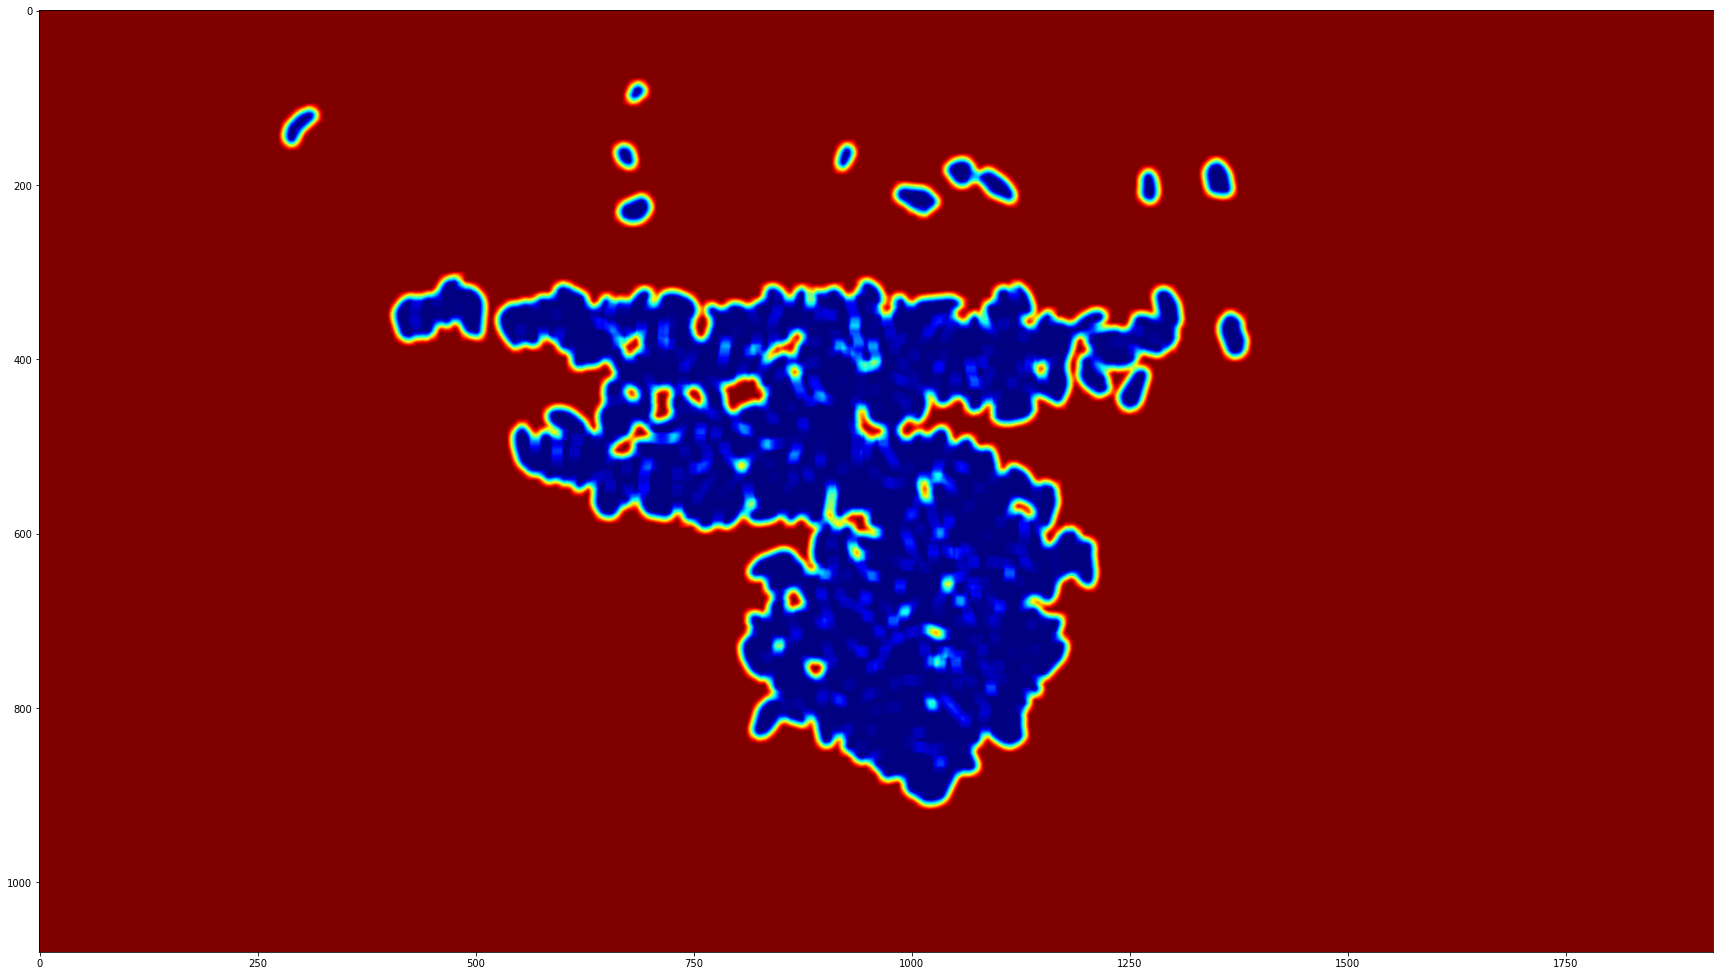

In [8]:
blur = cv2.GaussianBlur(image_mask,(13,13), 25)
heatmap_img = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
# super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, image_mask, 0.5, 0)
plt.figure(figsize=(30, 20))
plt.imshow(heatmap_img)

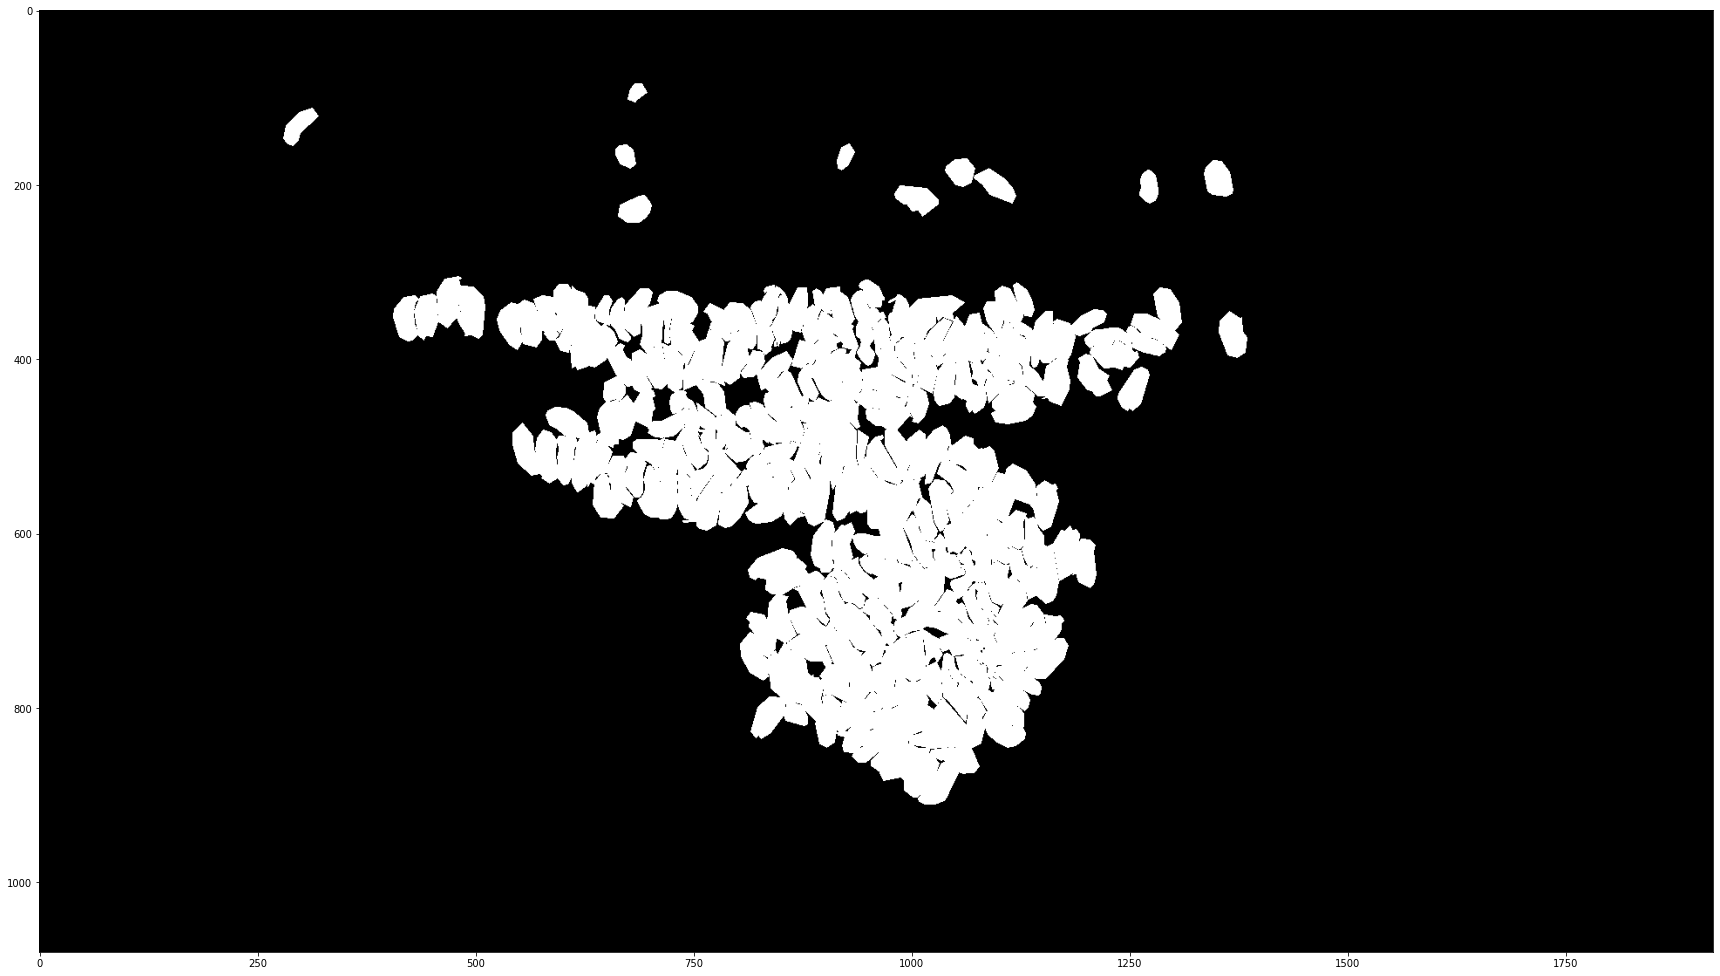

In [9]:
for image, markup in list(im_mark_pairs):
    image_file_name = image.split('/')[-1]
    image = cv2.imread(image)
    im_shape = image.shape
    json1_file = open(markup)
    json1_str = json1_file.read()
    json1_data = json.loads(json1_str)
#     print(im_shape, json1_data[0]['segmentation_poly'])
    image_to_mask(image, json1_data)
    
    image = image_to_mask(img_example, json1_data)
    
    plt.figure(figsize=(30, 20))
    plt.imshow(image)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite('./masks/'+image_file_name, image)
    break # FOR DEBUG

Центр полигона

In [10]:
points = np.array(json1_data[0]['segmentation_poly'], np.int32).reshape(-1,2)
x = [p[0] for p in points]
y = [p[1] for p in points]
centroid = (sum(x) / len(points), sum(y) / len(points))

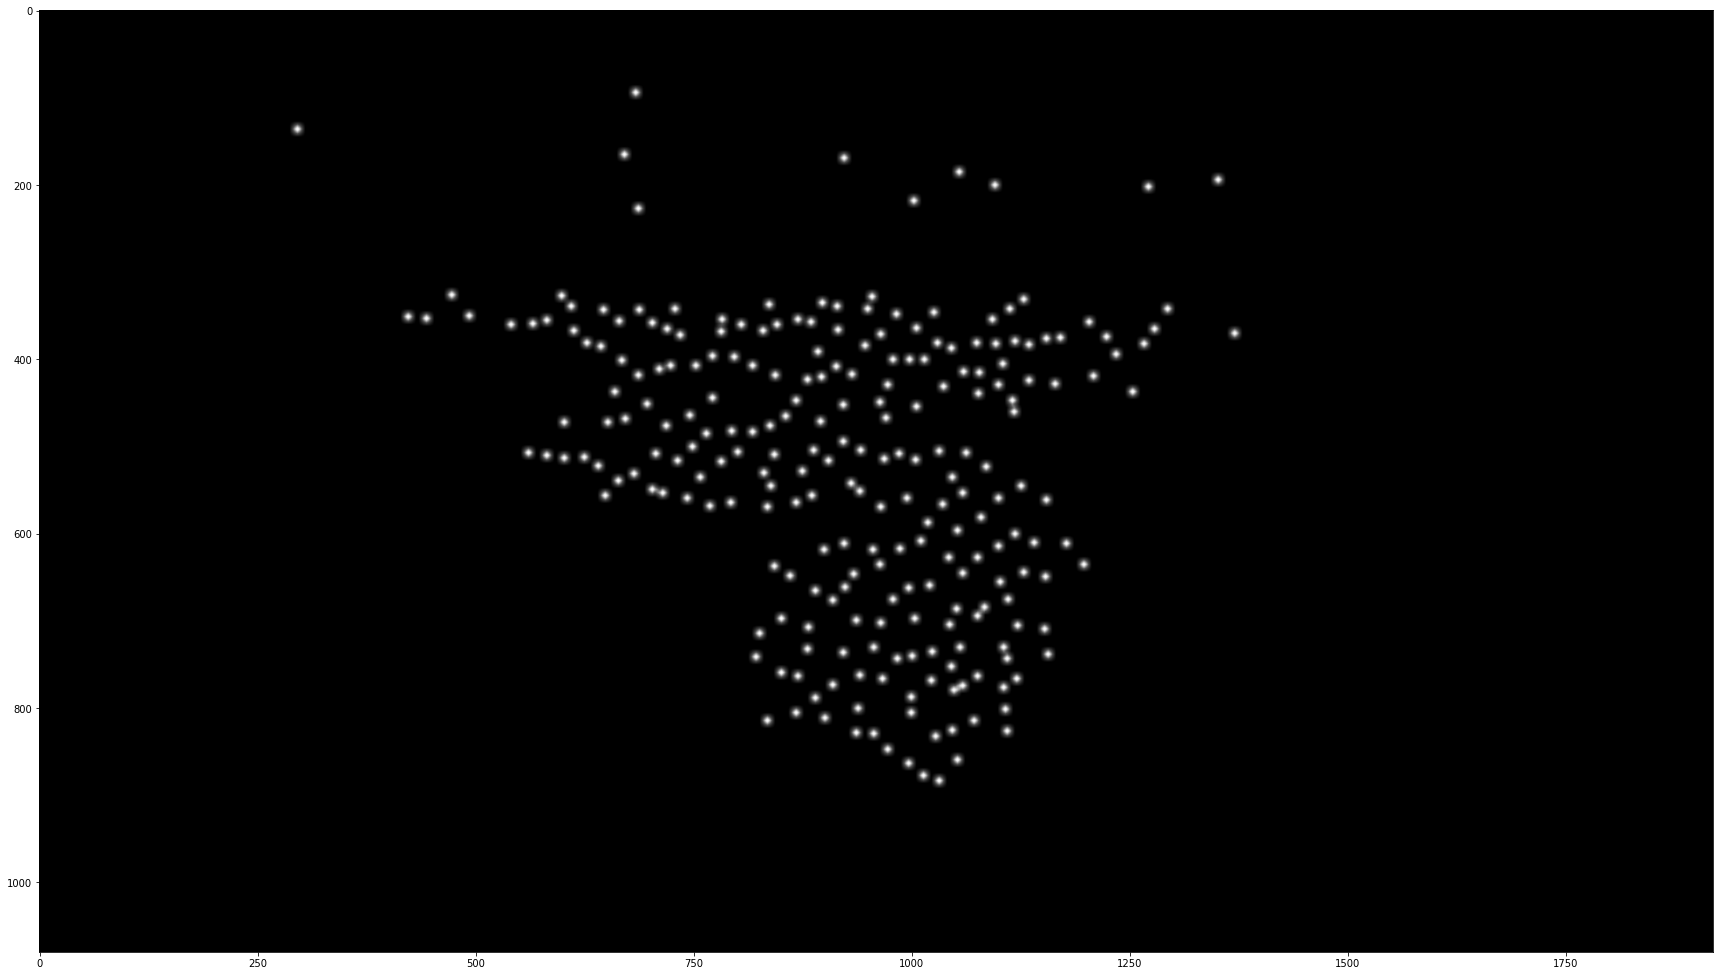

In [11]:
def image_to_heat_circles(img_example, markup):
    image = np.zeros((img_example.shape[0], img_example.shape[1], 3), np.uint8)
    image[:] = (0, 0, 0)

    for item in markup:
        pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
#         image = cv2.fillPoly(image, [pts], (255,255,255) )
        x = [p[0] for p in pts]
        y = [p[1] for p in pts]
        centroid = (sum(x) / len(pts), sum(y) / len(pts))
        cv2.circle(img=image, center = (np.int32(centroid[0]),np.int32(centroid[1])), radius =5, color =(255,255,255), thickness=-1)
        blur = cv2.GaussianBlur(image,(9,9), 10)
#         heat = cv2.applyColorMap(blur, cv2.COLORMAP_JET)
        heat = cv2.applyColorMap(blur, cv2.COLORMAP_HOT)
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2GRAY)
        
    return heat

image_heat = image_to_heat_circles(img_example, json1_data)
plt.figure(figsize=(30, 20))
plt.imshow(image_heat, cmap='gray')

<Figure size 2160x1440 with 0 Axes>

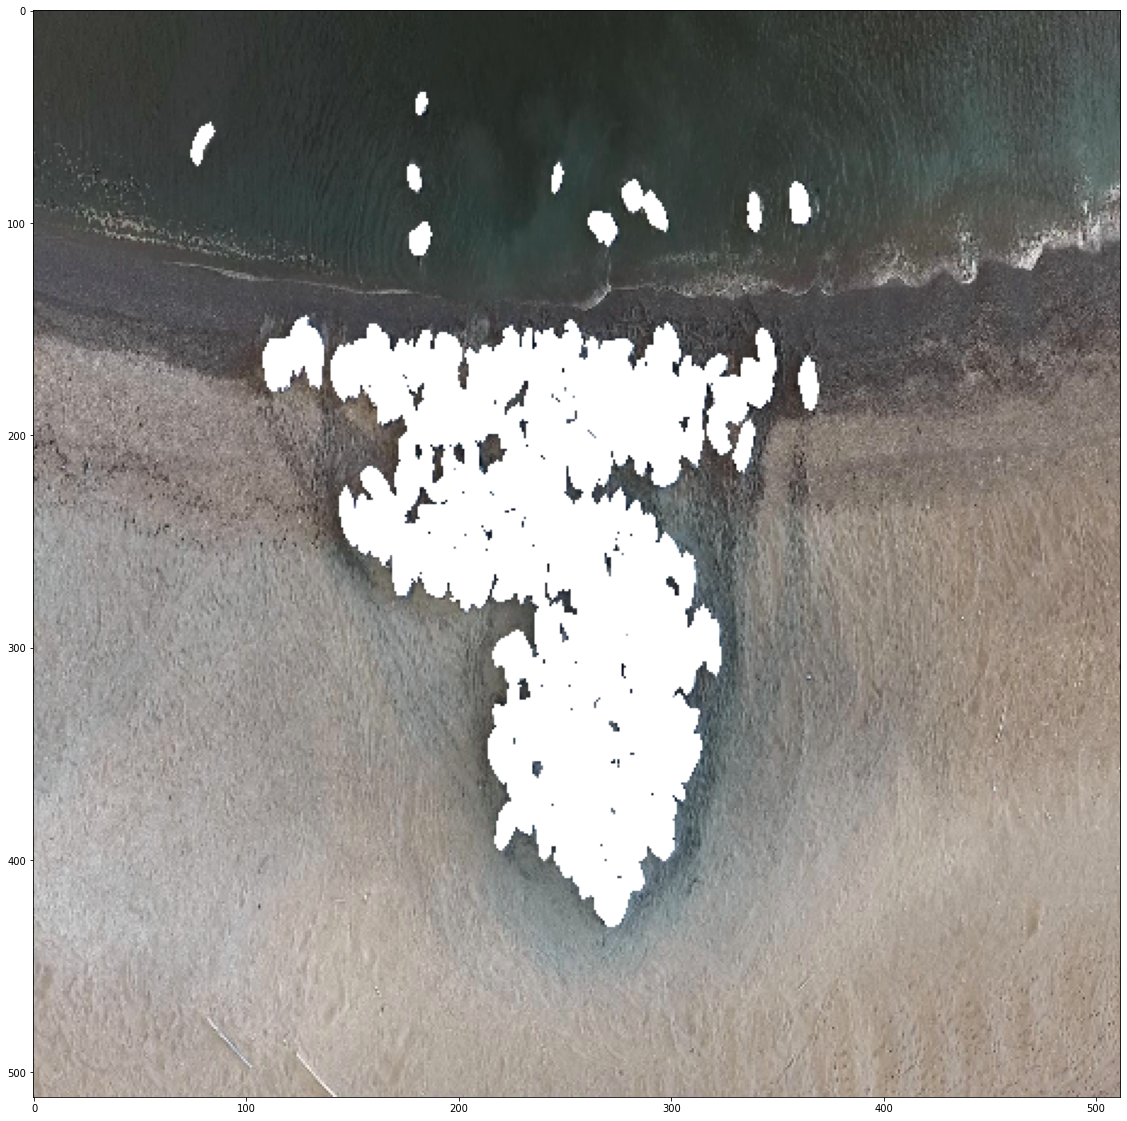

In [12]:
# resize image example
plt.figure(figsize=(30, 20))
img_example = cv2.imread(images_path + '/104.jpg')

def image_add_mask_resize(img_example, markup, countour=False):
#     image = np.zeros((img_example.shape[0], img_example.shape[1], 3), np.uint8)
#     image[:] = (0, 0, 0)
    im_shape = img_example.shape
    image = cv2.resize(img_example, (512, 512))
    r_x, r_y = im_shape[1]/512, im_shape[0]/512

    for item in markup:
        pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
        pts.T[0] = pts.T[0]/ r_x
        pts.T[1] = pts.T[1]/ r_y
        image = cv2.fillPoly(image, [pts], (255,255,255) )
        if countour:
            image = cv2.polylines(image, [pts], True, (255,0,0), 1)
        else:
            pass
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    return image

image_mask = image_add_mask_resize(img_example, json1_data)
plt.figure(figsize=(30, 20))
plt.imshow(image_mask)

In [13]:
r_x, r_y = im_shape[0]/512, im_shape[0]/512

Try resize polygons

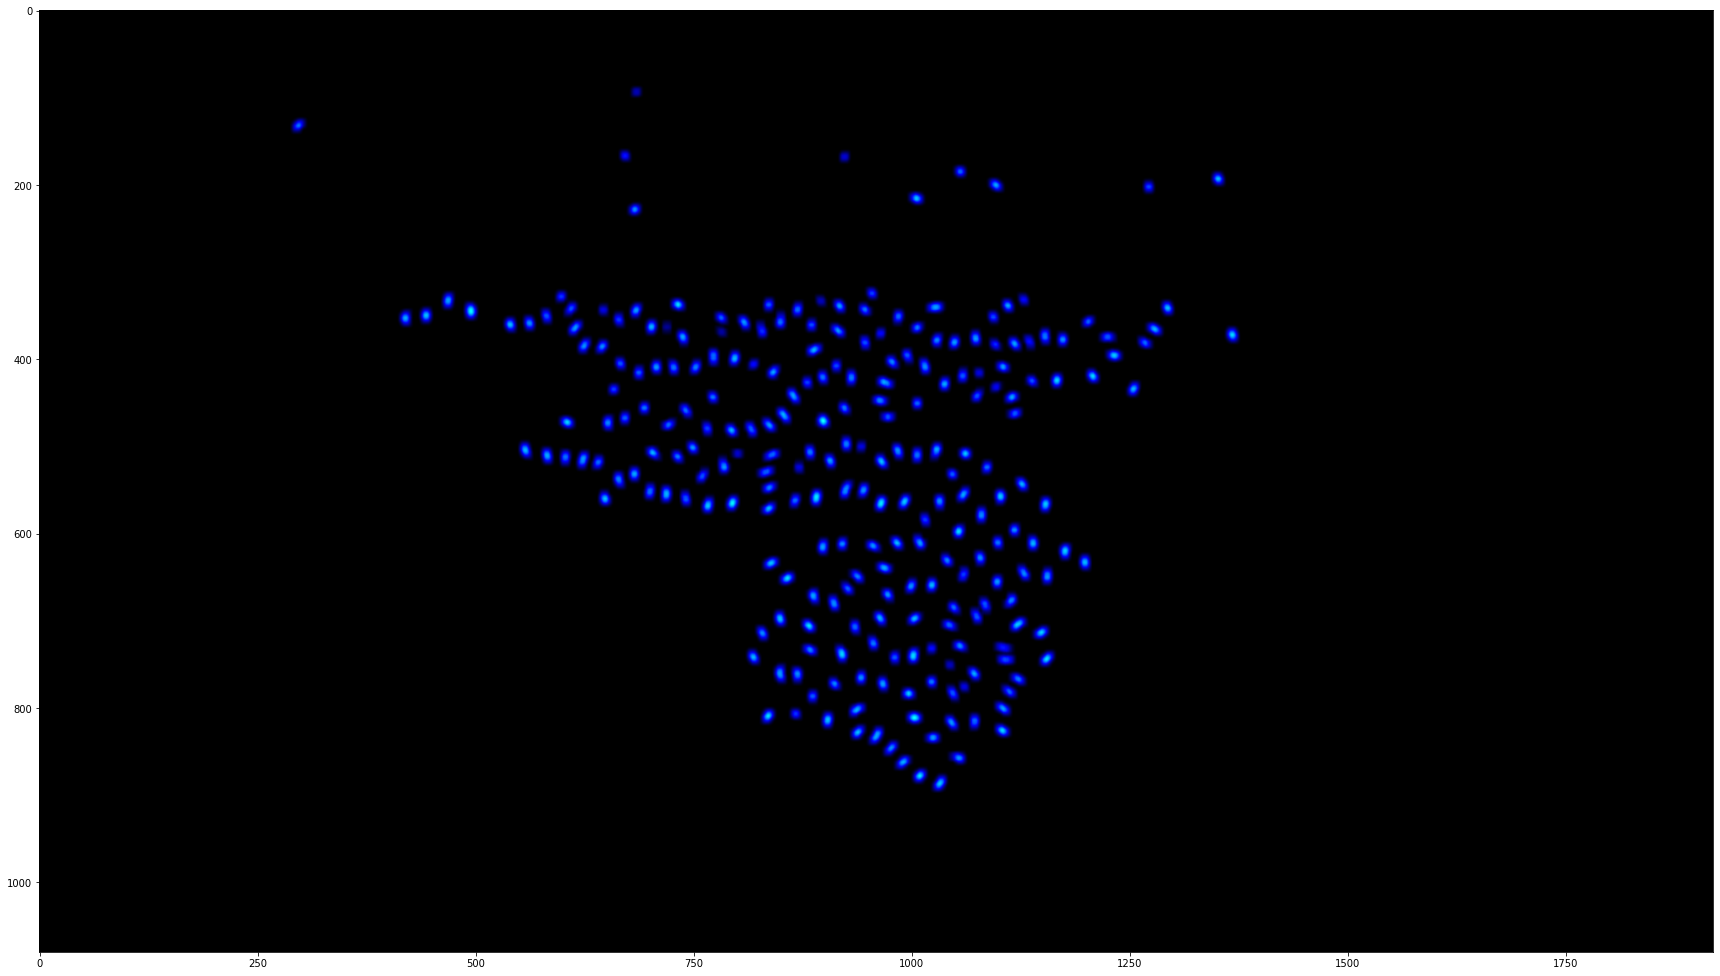

In [14]:
def center(x, y):
    diff = x[:-1] * y[1:] - x[1:] * y[:-1]
    coef = 1 / (diff.sum() * 3)
    return coef * ((x[:-1] + x[1:]) * diff).sum(), coef * ((y[:-1] + y[1:]) * diff).sum()

def image_to_heat(img_example, markup):
    image = np.zeros((img_example.shape[0], img_example.shape[1], 3), np.uint8)
    image[:] = (0, 0, 0)

    for item in markup:
        pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
        pts = np.vstack([pts, pts[0]])
        
        pos = np.array(center(*pts.T))
        multiple = 0.25
        new_pts = (pts - pos) * multiple + pos
        new_pts = np.array(new_pts, np.int32)
        image = cv2.fillPoly(image, [new_pts], (255,255,255) )
        
        blur = cv2.GaussianBlur(image,(11,11), 5)
        heat = cv2.applyColorMap(blur, cv2.COLORMAP_HOT)
        
    return heat

image_heat = image_to_heat(img_example, json1_data)
plt.figure(figsize=(30, 20))
plt.imshow(image_heat)

heatmap

In [15]:
import numpy
import cv2

def get_heatmap(image:np.ndarray, sizes, markup:list, heat_map_resize:bool=False, show_orig_image:bool=False) -> np.ndarray:
    
    orig_image = image.copy()
    
    image = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
    
    if show_orig_image:
        image = orig_image
    else:
        image[:] = (0, 0, 0)
    
    if image.shape[0] == 512:
        r_x, r_y = sizes[1]/512, sizes[0]/512
    
    for item in markup:
        pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
        
        if image.shape[0] == 512:
            pts.T[0] = pts.T[0]/ r_x
            pts.T[1] = pts.T[1]/ r_y
        
        x = [p[0] for p in pts]
        y = [p[1] for p in pts]
        
        centroid = (sum(x) / len(pts), sum(y) / len(pts))
        
        if image.shape[0] == 512:
            cv2.circle(img=image, center = (np.int32(centroid[0]),np.int32(centroid[1])), radius =2, color =(255,255,255), thickness=-1)
            blur = cv2.GaussianBlur(image,(3,3), 5) # BLUE PARAMETERS
        else:
            cv2.circle(img=image, center = (np.int32(centroid[0]),np.int32(centroid[1])), radius =5, color =(255,255,255), thickness=-1)
            blur = cv2.GaussianBlur(image,(9,9), 9) # BLUE PARAMETERS
        
#         blur = cv2.normalize(blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        if show_orig_image:
            heat = blur
        else:
            heat = cv2.applyColorMap(blur, cv2.COLORMAP_HOT)
            heat = cv2.cvtColor(heat, cv2.COLOR_BGR2GRAY)
    
    if heat_map_resize:
        return cv2.resize(heat, (sizes[1],sizes[0]))
    else:
        return heat

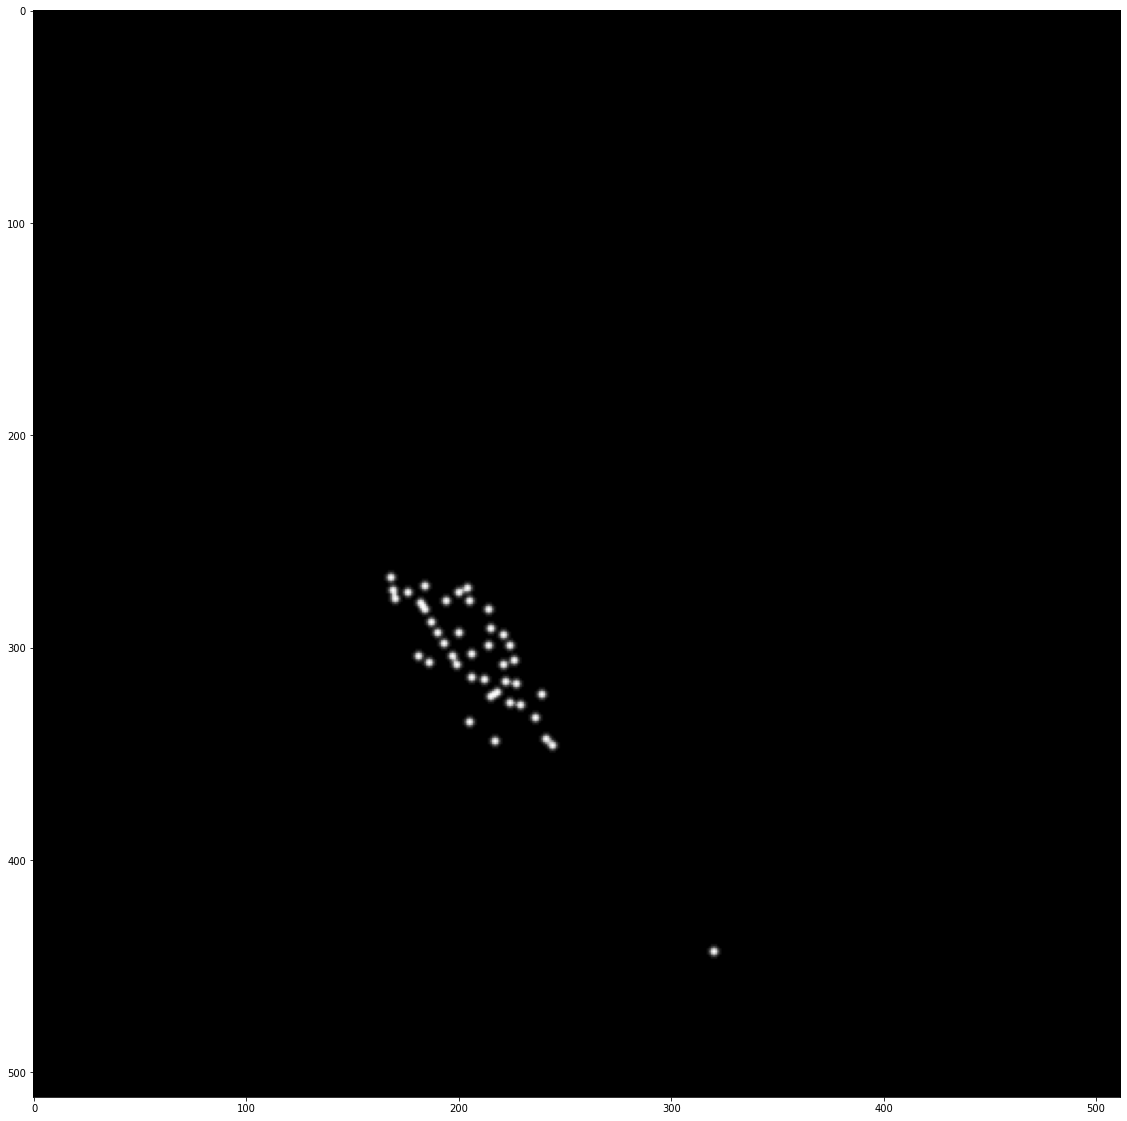

In [16]:
#test
img_example = cv2.imread(images_path + '/135.jpg')

json1_file = open(markup_path + '/135.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)


sizes=(img_example.shape[0], img_example.shape[1]) # (height, width)
img_example = cv2.resize(img_example, (512, 512))
image_heat = get_heatmap(image=img_example, sizes=sizes , markup=json1_data, heat_map_resize=False, show_orig_image=False)
plt.figure(figsize=(30, 20))
plt.imshow(image_heat, cmap='gray')

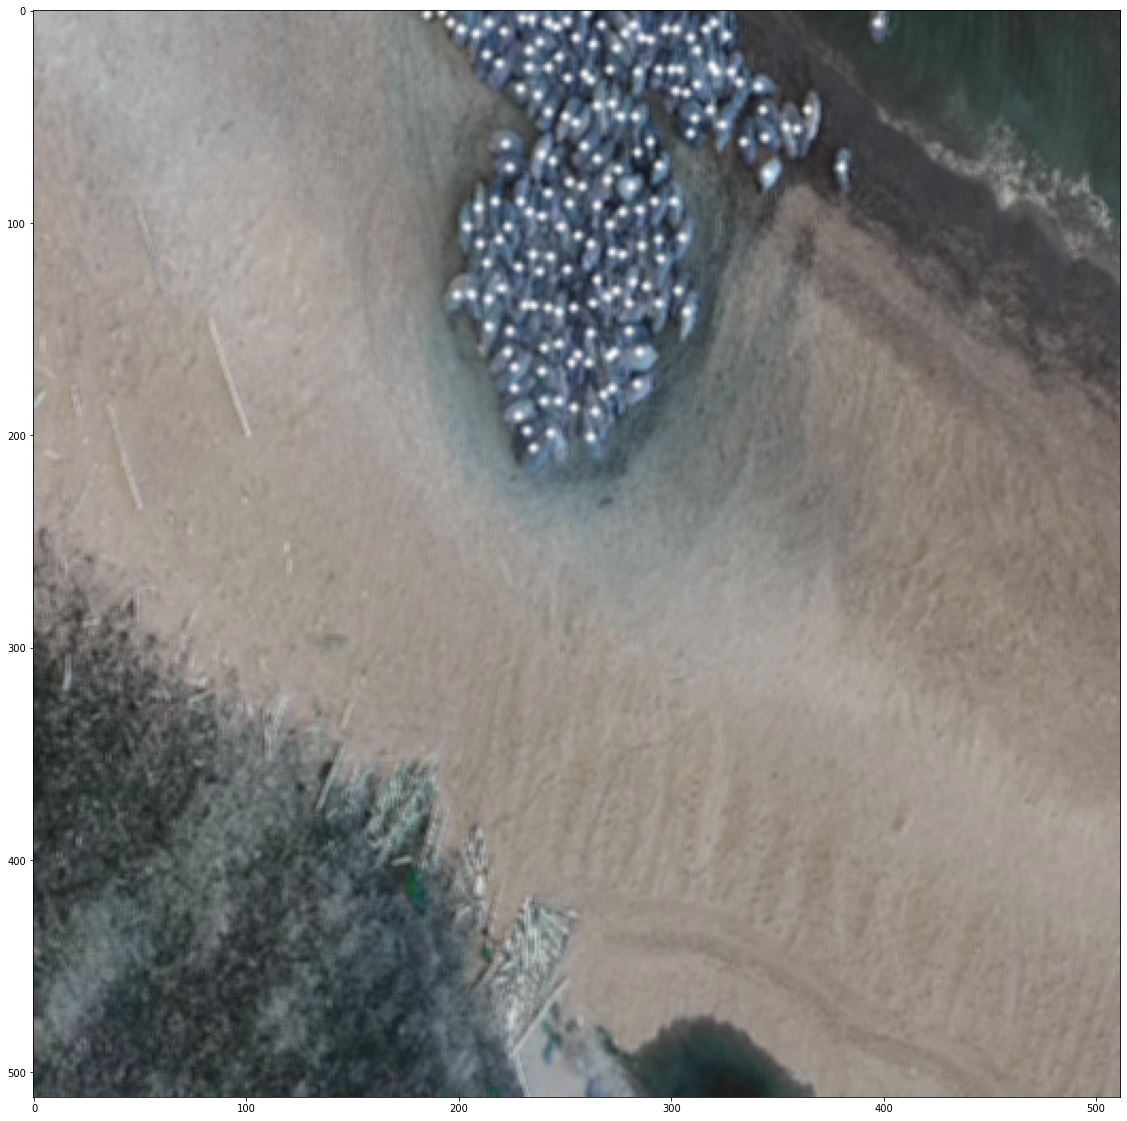

In [17]:
#test 2
img_example = cv2.imread(images_path + '/13.jpg')

json1_file = open(markup_path + '/13.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)


sizes=(img_example.shape[0], img_example.shape[1]) # (height, width)
img_example = cv2.resize(img_example, (512, 512))
image_heat = get_heatmap(image=img_example, sizes=sizes , markup=json1_data, heat_map_resize=False, show_orig_image=True)
plt.figure(figsize=(30, 20))
plt.imshow(image_heat, cmap='gray')

In [18]:
# Переводим в диапозон 0-1
image_heat_norm = image_heat / np.max(image_heat)

### Sliding

In [19]:
# def get_tiles(image, markup):
#     return 0

In [31]:
def get_tiles(img_example, markup_example, show_img=False, add_mask=True, mask_only=True, orig_polygons = True, countour=False):
    w_size = 512.0
#     overlap = 0 # ovelap(shift) w_size + overlap

    if (img_example.shape[0] % w_size) == 0:
        h_shifts = int(img_example.shape[0] / w_size)
    else:
        h_shifts = int(img_example.shape[0] / w_size) + 1

    if (img_example.shape[1] % w_size) == 0:
        w_shifts = int(img_example.shape[1] / w_size)
    else:
        w_shifts = int(img_example.shape[1] / w_size) + 1

    w_size = int(w_size)

    img_slices = []
    img_orig_slices = []
    

    for h_shift in range(h_shifts):
        for w_shift in range(w_shifts):
            image_slice = img_example[h_shift*w_size:(h_shift+1)*w_size, w_shift*w_size:(w_shift+1)*w_size]
            window = (h_shift*w_size,(h_shift+1)*w_size), (w_shift*w_size,(w_shift+1)*w_size)
#             print(window)
#             print(image_slice.shape[0], image_slice.shape[1])
            if (image_slice.shape[0] < w_size) or (image_slice.shape[1] < w_size): # padding
                image_slice = cv2.copyMakeBorder(image_slice, 0, w_size-image_slice.shape[0], 0, w_size-image_slice.shape[1], cv2.BORDER_CONSTANT)
#                 print(image_slice.shape)
            img_orig_slices.append(image_slice.copy())
                
            if mask_only:
                image_slice[:] = (0, 0, 0)
            
            if add_mask:
                h_start = window[0][0]
                w_start = window[1][0]
                for item in json1_data:
                    pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
                    pts.T[0] = pts.T[0] - w_start
                    pts.T[1] = pts.T[1] - h_start
                    x = [p[0] for p in pts]
                    y = [p[1] for p in pts]
                    
                    if orig_polygons:
                        image_slice = cv2.fillPoly(image_slice, [pts], (255,255,255) )
                        if countour:
                            image_slice = cv2.polylines(image_slice, [pts], True, (255,0,0), 1)
                    else:
                        centroid = (sum(x) / len(pts), sum(y) / len(pts))
                        cv2.circle(img=image_slice, center = (np.int32(centroid[0]),np.int32(centroid[1])), radius =5, color =(255,255,255), thickness=-1)
    #                     image_slice = cv2.fillPoly(image_slice, [pts], (255,255,255))
                        image_slice = cv2.GaussianBlur(image_slice,(3,3), 1)
                
            image_slice = cv2.cvtColor(image_slice, cv2.COLOR_BGR2GRAY)
            img_slices.append(image_slice)

            if show_img:
                plt.imshow(image_slice)
                plt.show()
    return img_slices, img_orig_slices, (h_shifts, w_shifts)


img_example = cv2.imread(images_path + '/104.jpg')
print(img_example.shape[0], img_example.shape[1])

json1_file = open(markup_path + '/104.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)

img_tiles, img_orig_tiles, num_tiles = get_tiles(img_example, json1_data, countour=False)
len(img_tiles), img_tiles[-1].shape, len(img_orig_tiles), img_orig_tiles[-1].shape

1080 1920


(12, (512, 512), 12, (512, 512, 3))

In [32]:
import torch
def img_mask_numpy_to_torch(img_tiles, img_orig_tiles):
    # img_tiles - masks
    # img_orig_tiles - images
    # return tuple of images, masks
    return torch.from_numpy(np.array(img_orig_tiles)), torch.from_numpy(np.array(img_tiles))
images_masks_pairs = img_mask_numpy_to_torch(img_tiles, img_orig_tiles)
images_masks_pairs[0].shape, images_masks_pairs[1].shape

(torch.Size([12, 512, 512, 3]), torch.Size([12, 512, 512]))

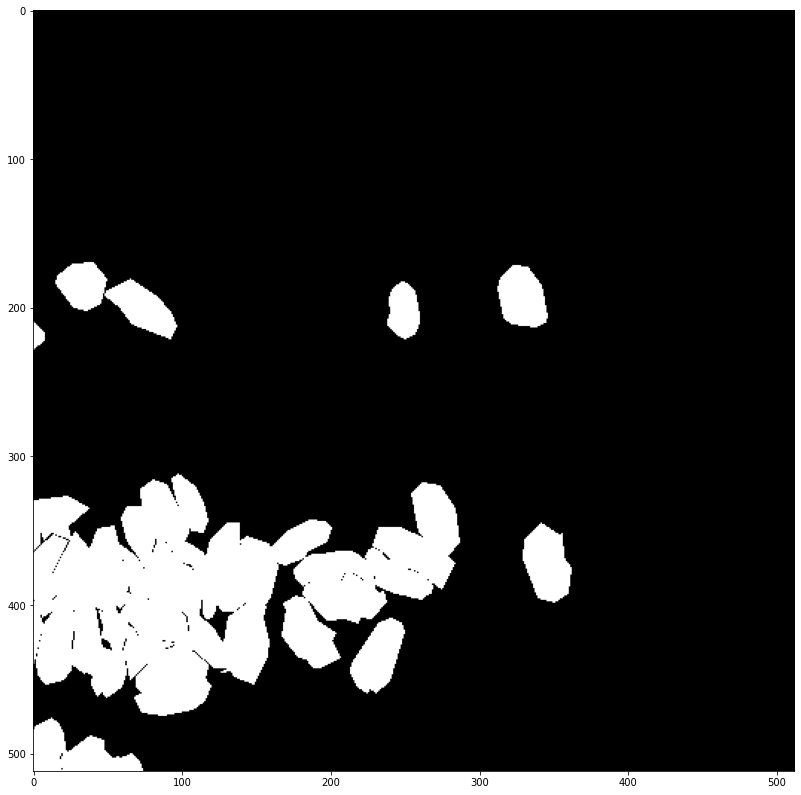

In [22]:
plt.figure(figsize=(20, 14))
plt.imshow(img_tiles[2])

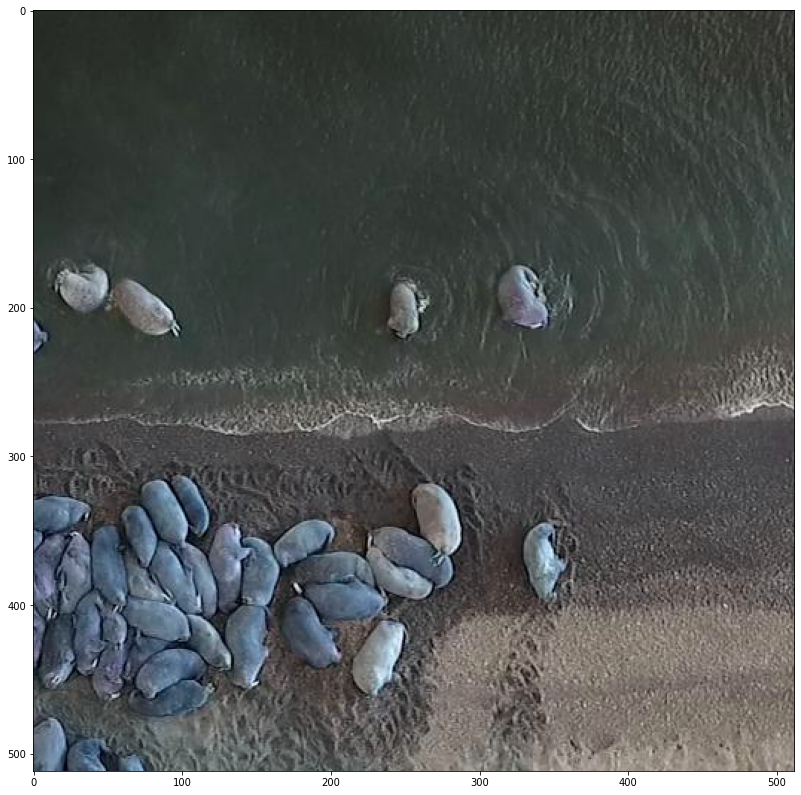

In [23]:
plt.figure(figsize=(20, 14))
plt.imshow(img_orig_tiles[2])

In [24]:
img_tiles[0].shape

(512, 512, 3)

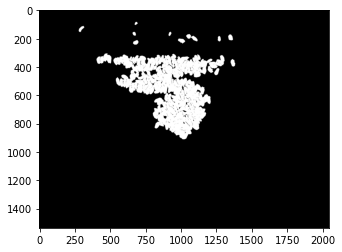

In [25]:
# Склейка
# orig resolution + padding

def concat_tiles(img_tiles, num_tiles):
    # img_tiles: list[nd.array]
    # num_tiles: tuple[int, int]
    w_size = 512
    image_concated = np.zeros([num_tiles[0]*w_size, num_tiles[1]*w_size, 3])
    image_concated.shape
    tile_index = 0

    for h_shift in range(num_tiles[0]):
        for w_shift in range(num_tiles[1]):
            window = (h_shift*w_size,(h_shift+1)*w_size), (w_shift*w_size,(w_shift+1)*w_size)
            image_concated[window[0][0]:window[0][1], window[1][0]:window[1][1]] = img_tiles[tile_index]
            tile_index += 1
    return image_concated

img_example = cv2.imread(images_path + '/13.jpg')
plt.imshow(concat_tiles(img_tiles, num_tiles))

test

In [26]:
def gen_density_map_gaussian(im, points, sigma=4):
    """
    func: generate the density map
    """
    density_map = np.zeros(im.shape[:2], dtype=np.float32)
    h, w = density_map.shape[:2]
    num_gt = np.squeeze(points).shape[0]
    if num_gt == 0:
        return density_map
    for p in points:
        p = np.round(p).astype(int)
        p[0], p[1] = min(h-1, p[1]), min(w-1, p[0])
        gaussian_radius = sigma * 2 - 1
        gaussian_map = np.multiply(
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma),
            cv2.getGaussianKernel(int(gaussian_radius*2+1), sigma).T
        )
        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        # cut the gaussian kernel
        if p[1] < gaussian_radius:
            x_left = gaussian_radius - p[1]
        if p[0] < gaussian_radius:
            y_up = gaussian_radius - p[0]
        if p[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + p[1] - w) - 1
        if p[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + p[0] - h) - 1
        gaussian_map = gaussian_map[y_up:y_down, x_left:x_right]
        if np.sum(gaussian_map):
            gaussian_map = gaussian_map / np.sum(gaussian_map)
        density_map[
            max(0, p[0]-gaussian_radius):min(h, p[0]+gaussian_radius+1),
            max(0, p[1]-gaussian_radius):min(w, p[1]+gaussian_radius+1)
        ] += gaussian_map
    density_map = density_map / (np.sum(density_map / num_gt))
    return density_map

In [27]:
img_example = cv2.imread(images_path + '/13.jpg')
print(img_example.shape[0], img_example.shape[1])

json1_file = open(markup_path + '/13.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)

points = []

for item in json1_data:
    pts = np.array(item['segmentation_poly'], np.int32).reshape(-1, 2)
    x = [p[0] for p in pts]
    y = [p[1] for p in pts]
    centroid = (sum(x) / len(pts), sum(y) / len(pts))
    points.append(centroid)

1080 1920


In [28]:
# density_map = gen_density_map_gaussian(img_example, np.array(points), sigma=4)
# plt.figure(figsize=(30, 20))
# plt.imshow(density_map)

In [29]:
# plt.figure(figsize=(30, 20))
# plt.imshow(density_map[0:512, 750:1250])